[View in Colaboratory](https://colab.research.google.com/github/tommybebe/til/blob/master/ml/daily_bitcoin_price_prediction.ipynb)

## Overview
- 가까운 미래의 기대값을 예측해보고 대응하기 위한 목적으로 예측 모델을 작성해보려 합니다.
- 목표로하는 형태는
$
\begin{align}
D_{n-29}... D_{n-3}, D_{n-2}, D_{n-1}, D_{n}
\end{align}
$
을 입력하고 
$
\begin{align}
D_{n+1}
\end{align}
$
을 구하는 것입니다.
- 단순히 예측 대상의 지난 시계열 데이터 외에 부가적인 feature를 넣어 학습에 도움이 되는지 또한 살펴보도록 하겠습니다.

## 데이터
- 데이터는 Kaggle  Dataset - all-crypto-currencies 를 활용합니다. 
- Kaggle API에 접근해 csv를 받아와 사용하겠습니다. 

### Kaggle Dataset 도움말
- [kaggle api accept / kaggle.json down](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-into-google-colab)
- key from https://www.kaggle.com/{name}/account

In [0]:
f = open('kaggle.json', 'w')
f.write('{"username":"minwoooo","key":"e861bf4e2ce694990439a4c0ea07f954"}')
f.close()

In [0]:
!pip install -q kaggle
!pip install tqdm

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d jessevent/all-crypto-currencies

 50%|██████████████████▉                   | 9.00M/18.0M [00:00<00:00, 27.5MB/s]
100%|██████████████████████████████████████| 18.0M/18.0M [00:00<00:00, 50.2MB/s]


In [0]:
!git clone https://github.com/mixuala/colab_utils

Cloning into 'colab_utils'...
remote: Counting objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 65.93 KiB | 3.66 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('crypto-markets.csv')
df.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.500520e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.491160e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.597780e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.542820e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.292190e+09,0.3881,33.32


In [0]:
import shutil
import tensorflow as tf
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from tensorflow.contrib import predictor

from sklearn.preprocessing import MinMaxScaler

import os
import requests
import shutil
import subprocess
from tqdm import tqdm

import numpy as np
import seaborn as sns

### 데이터 준비 
- 우선 대표적인 코인인 비트코인만을 학습 데이터로 사용하도록 합니다. 
- 학습을 위해 지난 n일간의 데이터를 각각 row에 feature의 형태로 정리합니다. 

In [0]:
btc = df.loc[df['slug']=='bitcoin']
btc.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.500520e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.491160e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.597780e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.542820e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.292190e+09,0.3881,33.32


In [0]:
seq_len = 30
label_name = 'close'
time_series_name = 'date'

def features():
  return [time_series_name, label_name, 'open', 'high', 'low', 'close_ratio']

def add_date_feature(df):
  _df = df.sort_values('date')
  dt = pd.to_datetime(df['date'])
  _df['year'] = dt.dt.year 
  _df['month'] = dt.dt.month 
  _df['day'] = dt.dt.day
  _df['weekday'] = dt.apply(lambda x: x.weekday())
  _df = _df.drop(['date'], axis=1)
  return _df

def minmax(df):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(df)
  return pd.DataFrame(scaled, columns=df.columns)

def generate_nested_sequences(df):
  loop_len = btc.shape[0] - seq_len
  seq_df = pd.DataFrame(columns=range(seq_len))
  for i in range(loop_len):
    seq_df.loc[i] = df.loc[i:i+seq_len-1, [label_name]].T.values[0]
  return pd.concat([btc[seq_len:].reset_index(drop=True), seq_df], axis=1)

def column_order_reset(df):
  columns = df.columns.tolist()
  columns.append(columns.pop(columns.index(label_name)))
  return df[columns]

btc = df.loc[df['slug']=='bitcoin', features()]
btc = add_date_feature(btc)
btc = minmax(btc)
btc = generate_nested_sequences(btc)
btc = column_order_reset(btc)
btc.tail()

,open,high,low,close_ratio,year,month,day,weekday,0,1,...,21,22,23,24,25,26,27,28,29,close
1831,0.384815,0.380789,0.393035,0.7362,1.0,0.454545,0.033333,0.833333,0.497990,0.495772,...,0.386995,0.381477,0.375082,0.375717,0.363764,0.381089,0.377688,0.382199,0.384633,0.389883
1832,0.389729,0.383739,0.399158,0.7558,1.0,0.454545,0.066667,1.000000,0.495772,0.503872,...,0.381477,0.375082,0.375717,0.363764,0.381089,0.377688,0.382199,0.384633,0.389883,0.393836
1833,0.394389,0.383686,0.391807,0.1445,1.0,0.454545,0.100000,0.000000,0.503872,0.493406,...,0.375082,0.375717,0.363764,0.381089,0.377688,0.382199,0.384633,0.389883,0.393836,0.383244
1834,0.382969,0.378160,0.387733,0.9615,1.0,0.454545,0.133333,0.166667,0.493406,0.478902,...,0.375717,0.363764,0.381089,0.377688,0.382199,0.384633,0.389883,0.393836,0.383244,0.389384
1835,0.389414,0.380019,0.393286,0.8518,1.0,0.454545,0.166667,0.333333,0.478902,0.471790,...,0.363764,0.381089,0.377688,0.382199,0.384633,0.389883,0.393836,0.383244,0.389384,0.390425


In [0]:
split_point = int(round(btc.shape[0]*0.7))
train = btc[:split_point]
valid = btc[split_point:]

train.to_csv('train.csv', index=False, header=False)
valid.to_csv('valid.csv', index=False, header=False)

## Model


### 모델 준비
- [Estimator API와 LSTM, RNN 구성의 예시](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/deepdive/09_sequence)를 참고합니다.
- estimator로 감싼 RNN 모델을 train_and_evaluate로 묶어 정리해두고
- 필요한만큼 재사용할 수 있도록 하겠습니다. 

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

TIMESERIES_COL = 'height'
N_OUTPUTS = 1  
SEQ_LEN = None
DEFAULTS = None
N_INPUTS = None

def init(hparams):
  global SEQ_LEN, DEFAULTS, N_INPUTS
  SEQ_LEN =  hparams['sequence_length']
  DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
  N_INPUTS = SEQ_LEN - N_OUTPUTS

def lstm_model(features, mode, params):
  LSTM_SIZE = N_INPUTS//3  # size of the internal state in each of the cells

  # 1. dynamic_rnn needs 3D shape: [BATCH_SIZE, N_INPUTS, 1]
  x = tf.reshape(features[TIMESERIES_COL], [-1, N_INPUTS, 1])

  # 2. configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
  outputs, _ = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)
  outputs = outputs[:, (N_INPUTS-1):, :]  # last cell only

  # 3. flatten lstm output and pass through a dense layer
  lstm_flat = tf.reshape(outputs, [-1, lstm_cell.output_size])
  h1 = tf.layers.dense(lstm_flat, N_INPUTS//2, activation=tf.nn.relu)
  predictions = tf.layers.dense(h1, 1, activation=None) # (?, 1)
  return predictions

# 2-layer LSTM
def lstm2_model(features, mode, params):
  # dynamic_rnn needs 3D shape: [BATCH_SIZE, N_INPUTS, 1]
  x = tf.reshape(features[TIMESERIES_COL], [-1, N_INPUTS, 1])
 
  # 2. configure the RNN
  lstm_cell1 = rnn.BasicLSTMCell(N_INPUTS*2, forget_bias=1.0)
  lstm_cell2 = rnn.BasicLSTMCell(N_INPUTS//2, forget_bias=1.0)
  lstm_cells = rnn.MultiRNNCell([lstm_cell1, lstm_cell2])
  outputs, _ = tf.nn.dynamic_rnn(lstm_cells, x, dtype=tf.float32)
  outputs = outputs[:, (N_INPUTS-1):, :] # last one only

  # 3. flatten lstm output and pass through a dense layer
  lstm_flat = tf.reshape(outputs, [-1, lstm_cells.output_size])
  h1 = tf.layers.dense(lstm_flat, lstm_cells.output_size//2, activation=tf.nn.relu)
  predictions = tf.layers.dense(h1, 1, activation=None) # (?, 1)
  return predictions

# create N-1 predictions
def lstmN_model(features, mode, params):
  # dynamic_rnn needs 3D shape: [BATCH_SIZE, N_INPUTS, 1]
  x = tf.reshape(features[TIMESERIES_COL], [-1, N_INPUTS, 1])
 
  # 2. configure the RNN
  lstm_cell1 = rnn.BasicLSTMCell(N_INPUTS*2, forget_bias=1.0)
  lstm_cell2 = rnn.BasicLSTMCell(N_INPUTS//2, forget_bias=1.0)
  lstm_cells = rnn.MultiRNNCell([lstm_cell1, lstm_cell2])
  outputs, _ = tf.nn.dynamic_rnn(lstm_cells, x, dtype=tf.float32)

  # 3. make lstm output a 2D matrix and pass through a dense layer
  # so that the dense layer is shared for all outputs
  lstm_flat = tf.reshape(outputs, [-1, N_INPUTS, lstm_cells.output_size])
  h1 = tf.layers.dense(lstm_flat, lstm_cells.output_size, activation=tf.nn.relu)
  h2 = tf.layers.dense(h1, lstm_cells.output_size//2, activation=tf.nn.relu)
  predictions = tf.layers.dense(h2, 1, activation=None) # (?, N_INPUTS, 1)
  predictions = tf.reshape(predictions, [-1, N_INPUTS])
  return predictions

# read data and convert to needed format
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    def decode_csv(row):
      #row is a string tensor containing the contents of one row
      features = tf.decode_csv(row, record_defaults = DEFAULTS) #string tensor -> list of 50 rank 0 float tensors
      label = features.pop() #remove last feature and use as label
      features = tf.stack(features) #list of rank 0 tensors -> single rank 1 tensor
      return {TIMESERIES_COL: features}, label

    # Create list of file names that match "glob" pattern (i.e. data_file_*.csv)
    dataset = tf.data.Dataset.list_files(filename) 
    # Read in data from files
    dataset = dataset.flat_map(tf.data.TextLineDataset)
    # Parse text lines as comma-separated values (CSV)
    dataset = dataset.map(decode_csv)

    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # loop indefinitely
        dataset = dataset.shuffle(buffer_size = 10 * batch_size)
    else:
        num_epochs = 1 # end-of-input after this

    dataset = dataset.repeat(num_epochs).batch(batch_size)
    return dataset.make_one_shot_iterator().get_next()
  return _input_fn

def serving_input_fn():
    feature_placeholders = {
        TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
    }
  
    features = {
      key: tf.expand_dims(tensor, -1)
      for key, tensor in feature_placeholders.items()
    }
    features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2])

    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

def compute_errors(features, labels, predictions):
   labels = tf.expand_dims(labels,-1) #rank 1 -> rank 2 to match rank of predictions

   if predictions.shape[1] == 1:
      loss = tf.losses.mean_squared_error(labels, predictions)
      rmse = tf.metrics.root_mean_squared_error(labels, predictions)
      return loss, rmse
   else:
      # one prediction for every input in sequence
      # get 1-N of (x + label)
      labelsN = tf.concat([features[TIMESERIES_COL], labels], axis=1)
      labelsN = labelsN[:, 1:]
      # loss is computed from the last 1/3 of the series
      N = (2 * N_INPUTS) // 3
      loss = tf.losses.mean_squared_error(labelsN[:, N:], predictions[:, N:])
      # rmse is computed from last prediction and last label
      lastPred = predictions[:, -1]
      rmse = tf.metrics.root_mean_squared_error(labels, lastPred)
      return loss, rmse

# create the inference model
def sequence_regressor(features, labels, mode, params):
  # 1. run the appropriate model
  model_functions = {
      'lstm':lstm_model,
      'lstm2':lstm2_model,
      'lstmN':lstmN_model}
  model_function = model_functions[params['model']]
  predictions = model_function(features, mode, params)

  # 2. loss function, training/eval ops
  loss = None
  train_op = None
  eval_metric_ops = None
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
     loss, rmse = compute_errors(features, labels, predictions)

     if mode == tf.estimator.ModeKeys.TRAIN:
        # this is needed for batch normalization, but has no effect otherwise
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
           # 2b. set up training operation
           train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.train.get_global_step(),
              learning_rate=params['learning_rate'],
              optimizer="Adam")
 
     # 2c. eval metric
     eval_metric_ops = {
      "rmse": rmse
     }

  # 3. Create predictions
  if predictions.shape[1] != 1:
     predictions = predictions[:, -1] # last predicted value
  predictions_dict = {"predicted": predictions}

  # 4. return EstimatorSpec
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops,
      export_outputs={
          'predictions': tf.estimator.export.PredictOutput(predictions_dict)}
  )

def train_and_evaluate(output_dir, hparams):
  get_train = read_dataset(hparams['train_data_path'],
                                   tf.estimator.ModeKeys.TRAIN,
                                   hparams['train_batch_size'])
  get_valid = read_dataset(hparams['eval_data_path'],
                                   tf.estimator.ModeKeys.EVAL,
                                   1000)
  estimator = tf.estimator.Estimator(model_fn = sequence_regressor,
                                   params = hparams,
                                   config = tf.estimator.RunConfig()\
                                     .replace(session_config=tf.ConfigProto(log_device_placement=True, device_count={'GPU': 1})),
                                   model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = get_train,
                                   max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = get_valid,
                                  steps = None,
                                  exporters = exporter,
                                  start_delay_secs = hparams['eval_delay_secs'],
                                  throttle_secs = hparams['min_eval_frequency'])
  return tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

### 학습 시작

- 적절한 Hyper Parameter를 찾을 때까지 돌려보..
- ..기에는 시간이 굉장히 소요되므로 적절히 눈치보면서 좋은 숫자를 찾아보겠습니다.

In [0]:
hparams = {
    "train_data_path": "train.csv",
    "eval_data_path": "valid.csv",
    "output_dir": "trained/sines",
    "train_batch_size": 500,
    "train_steps": 10000,
    "learning_rate": 0.00001,
    "sequence_length": train.shape[1],
    "eval_delay_secs": 10,
    "min_eval_frequency": 60,
    "model": "lstmN"
}

init(hparams)

shutil.rmtree(hparams['output_dir'], ignore_errors=True)
fit = train_and_evaluate(hparams['output_dir'], hparams)

INFO:tensorflow:Using config: {'_model_dir': 'trained/sines', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
  value: 1
}
log_device_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8d3c398a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INF

In [0]:
model_dir = fit[1][0]

In [0]:
import colab_utils.tboard

# set paths
ROOT = %pwd
LOG_DIR = os.path.join(ROOT, 'log')

colab_utils.tboard.launch_tensorboard( bin_dir=ROOT, log_dir=model_dir )

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
tensorboard url= http://c9d724a2.ngrok.io


'http://c9d724a2.ngrok.io'

## Predict

### 두가지 예측 준비
1. validation dataset 모든 행의 feature를 사용해 close 값을 예측해보고 시계열 형태로 뿌려주겠습니다. 
2. validation dataset의 첫번째 행을 사용해 close 값을 예측해보고 나온 값을 다음 행에 붙여 다시 예측.. 하는 과정을 반복해 전체 시계열 데이터를 구성해보겠습니다.

In [0]:
def generate_pred_with_sample_data(input):
  pred = predict_fn({ 'height': input })['predicted'].reshape(-1)
  return pred

def generate_pred_with_first_row(first_row, n):
  input = first_row
  output = []
  with tqdm(range(n)) as q:
    for i in q:
      pred = predict_fn({ 'height': [input] })['predicted'].reshape(1)
      input = input[1:]
      input = np.concatenate([input, pred])
      output.append(input)
  return output

predict_fn = predictor.from_saved_model(model_dir)
test_1 = generate_pred_with_sample_data(valid.iloc[:, :-1].values.tolist())
test_2 = generate_pred_with_first_row(valid.iloc[0, :-1].values, len(valid))

INFO:tensorflow:Restoring parameters from trained/sines/export/exporter/1534780284/variables/variables


100%|██████████| 551/551 [00:24<00:00, 22.89it/s]


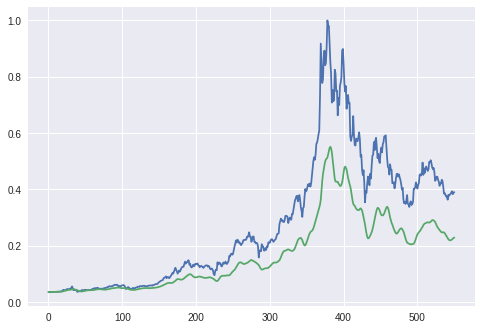

In [0]:
plt.plot(valid.iloc[:, -1].values)
plt.plot(np.array(test_1))

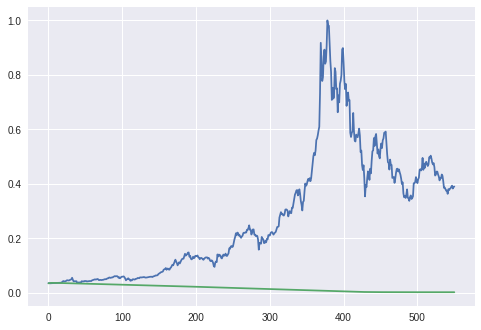

In [0]:
plt.plot(valid.iloc[:, -1].values)
plt.plot(np.array(test_2)[:,-1])

### result
- 하루치 예측은 비교적 잘 따라가는 모습으로 확인됩니다만, 
- 긴 시간을 예측하는데에는 무리가 있었습니다.